# **Predicción de demanda de productos**

El objetivo del modelo predictivo será  units_sold. Este modelo puede permitir a la empresa:  
- Optimizar inventarios: Reducir el exceso de stock o faltantes.
- Planificación de producción: Ajustar la oferta según la demanda prevista.
- Estrategias de precios: Analizar el impacto del precio en las ventas.
- Estrategias geográficas: Identificar patrones en diferentes ubicaciones.

Para realizar el modelo de Machine Learning:

1. Realizaremos un exploratorio inicial breve.
2. Tratamiento de las fechas para predecir la demanda.
3. Eliminamos columnas que no aportan relevancia al proyecto.
4. Eliminamos registro que no aportan en el modelo predictivo.
5. Manejo de variables categóricas.
6. Reordenamos las columnas para establecemos a la variable objetivo: **units_sold**.
7. Analizamos las correlaciones de las variables independientes respecto a la variable objetivo.
8. Elección de las variables para el modelo.

### Librerías necesarias

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

###  DataFrame Final

In [59]:
# Leemos el DataFrame Final
df = pd.read_csv('..\\data\\df_final.csv')

## 1. Exploratorio inicial

In [60]:
# Comprobamos que no hay valores nulos
df.isnull().sum()

sale_id           0
sale_date         0
store_id          0
store_name        0
location          0
manager           0
opening_date      0
product_id        0
product_name      0
category          0
product_price     0
product_cost      0
launch_date       0
product_status    0
units_sold        0
total_cost        0
total_revenue     0
profit            0
dtype: int64

In [61]:
# Comprobamos los tipos de datos
df.dtypes

sale_id             int64
sale_date          object
store_id            int64
store_name         object
location           object
manager            object
opening_date       object
product_id          int64
product_name       object
category           object
product_price     float64
product_cost      float64
launch_date        object
product_status     object
units_sold          int64
total_cost        float64
total_revenue     float64
profit            float64
dtype: object

In [62]:
# Estadísticas descriptivas de la columna objetivo (units_sold)
df['units_sold'].describe()


count    33.000000
mean      2.484848
std       1.872852
min       1.000000
25%       1.000000
50%       2.000000
75%       3.000000
max      10.000000
Name: units_sold, dtype: float64

In [63]:
# Agrupamos por product_id y calcula la media, desviación estándar, mínimo, máximo y suma de unidades vendidas
unidades_vendidads_stadistics = df.groupby('product_id')['units_sold'].agg(['mean', 'std', 'min', 'max', 'sum']).reset_index()
unidades_vendidads_stadistics

,product_id,mean,std,min,max,sum
0,101,5.250000,3.403430,2,10,21
1,102,3.000000,NaN,3,3,3
2,103,2.000000,NaN,2,2,2
3,104,1.000000,NaN,1,1,1
4,105,1.500000,0.707107,1,2,3
5,106,1.000000,NaN,1,1,1
6,107,2.000000,NaN,2,2,2
7,108,1.500000,0.707107,1,2,3
8,109,1.000000,NaN,1,1,1
9,110,2.500000,0.707107,2,3,5


In [64]:
# Convertimos las columnas de fecha a formato datetime
date_columns = ['sale_date', 'opening_date', 'launch_date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

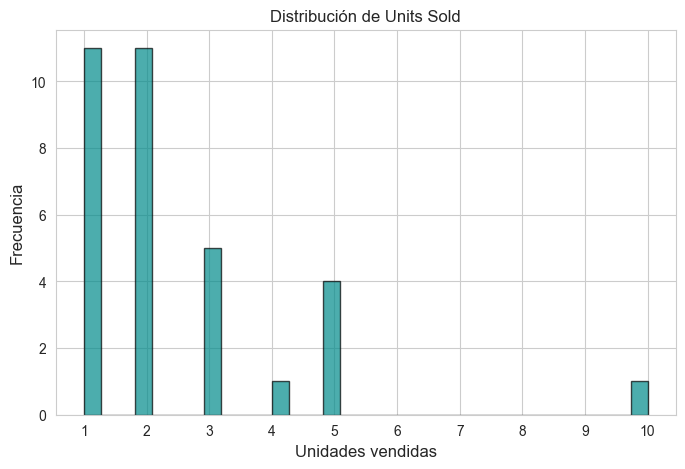

In [65]:
# Gráfico de la distribución de `units_sold`
plt.figure(figsize=(8, 5))
sns.set_style('whitegrid')
plt.hist(df['units_sold'], bins=33, edgecolor='black', alpha=0.7, color='darkcyan')
plt.title('Distribución de Units Sold')
plt.xlabel('Unidades vendidas', fontsize=12)
plt.xticks(range(df['units_sold'].min(), df['units_sold'].max() + 1))
plt.ylabel('Frecuencia', fontsize=12)
plt.show()

- La mayoría de las ventas corresponden a pocas unidades

## 2. Tratamiento de las fechas para predecir la demanda

In [66]:
# Extraemos características de la columna `sale_date`
df['sale_month'] = df['sale_date'].dt.month
df['sale_day'] = df['sale_date'].dt.day
df['sale_weekday'] = df['sale_date'].dt.weekday  # 0: Lunes, 6: Domingo
df['is_weekend'] = df['sale_weekday'].isin([5, 6]).astype(int)  # 1 si es fin de semana, 0 si no

In [67]:
# Calculamos días desde eventos clave
df['days_since_opening'] = (df['sale_date'] - df['opening_date']).dt.days
df['days_since_launch'] = (df['sale_date'] - df['launch_date']).dt.days

In [68]:
# Verificamos las transformaciones realizadas
df[['sale_date', 'sale_month', 'sale_day', 'sale_weekday',
    'is_weekend', 'days_since_opening', 'days_since_launch']].head()

,sale_date,sale_month,sale_day,sale_weekday,is_weekend,days_since_opening,days_since_launch
0,2023-01-02,1,2,0,0,357,1
1,2023-01-03,1,3,1,0,358,-12
2,2023-01-03,1,3,1,0,358,-29
3,2023-01-15,1,15,6,1,344,75
4,2023-02-10,2,10,4,0,370,71


In [69]:
# Reemplazamos valores negativos en `days_since_launch` con 0, ya que no pueden ser negativos
# Hubo un mal registro en la fecha de lanzamiento
df['days_since_launch'] = df['days_since_launch'].where(df['days_since_launch'] >= 0, 0)
# Volvemos a verificar las transformaciones realizadas
df[['sale_date', 'sale_month', 'sale_day', 'sale_weekday',
    'is_weekend', 'days_since_opening', 'days_since_launch']].head()

,sale_date,sale_month,sale_day,sale_weekday,is_weekend,days_since_opening,days_since_launch
0,2023-01-02,1,2,0,0,357,1
1,2023-01-03,1,3,1,0,358,0
2,2023-01-03,1,3,1,0,358,0
3,2023-01-15,1,15,6,1,344,75
4,2023-02-10,2,10,4,0,370,71


## 3. Eliminamos columnas que no aportan relevancia al proyecto

In [70]:
# Columnas del DataFrame inicial
df.columns

Index(['sale_id', 'sale_date', 'store_id', 'store_name', 'location', 'manager',
       'opening_date', 'product_id', 'product_name', 'category',
       'product_price', 'product_cost', 'launch_date', 'product_status',
       'units_sold', 'total_cost', 'total_revenue', 'profit', 'sale_month',
       'sale_day', 'sale_weekday', 'is_weekend', 'days_since_opening',
       'days_since_launch'],
      dtype='object')

In [71]:
# Eliminamos columnas que no aportan relevancia al proyecto:
df.drop(['sale_id', 'sale_date','store_name', 'manager', 'product_name', 'opening_date', 'launch_date'], axis=1, inplace=True)

## 4. Eliminamos registro que no aportan en el modelo predictivo

In [72]:
# Registros con productos descontinuados ya que están descatalogados
df[df['product_status'] == 'discontinued']
# Eliminamos los productos descontinuados
df = df[df['product_status'] != 'discontinued']

In [73]:
# Eliminamos los registros con store_id 999 ya que no aportan información y tenía registros de desconocido.
df = df[df['store_id'] != 999]

## 5. Manejo de variables categóricas 
- Variables categóricas actuales: category, product_status y location

In [74]:
# Creamos mapeos para las variables categóricas
category_mapping = {category: idx for idx, category in enumerate(df['category'].unique())}
product_status_mapping = {status: idx for idx, status in enumerate(df['product_status'].unique())}
location_mapping = {location: idx for idx, location in enumerate(df['location'].unique())}

In [75]:
# Aplicamos los mapeos al DataFrame
df['category'] = df['category'].map(category_mapping)
df['product_status'] = df['product_status'].map(product_status_mapping)
df['location'] = df['location'].map(location_mapping)

# Verificar los resultados de la codificación
df[['category', 'product_status', 'location']].head()

,category,product_status,location
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,1
4,0,1,1


In [76]:
# Comprobamos los tipos de datos
print("Category Mapping:", category_mapping)
print("Product Status Mapping:", product_status_mapping)
print("Location Mapping:", location_mapping)


Category Mapping: {'Electrodomesticos': 0, 'Electronica': 1, 'Hogar': 2}
Product Status Mapping: {'active': 0, 'paused': 1}
Location Mapping: {'Madrid': 0, 'Barcelona': 1, 'Sevilla': 2, 'Valencia': 3, 'Itinerante': 4, 'Online': 5, 'Bilbao': 6}


## 6. Reordenamos las columnas para establecemos a la variable objetivo: **units_sold**

In [77]:
df.columns

Index(['store_id', 'location', 'product_id', 'category', 'product_price',
       'product_cost', 'product_status', 'units_sold', 'total_cost',
       'total_revenue', 'profit', 'sale_month', 'sale_day', 'sale_weekday',
       'is_weekend', 'days_since_opening', 'days_since_launch'],
      dtype='object')

In [78]:
# Reordenamos las columnas del DataFrame y situamos la columna objetivo al final
df = df[['store_id', 'location', 'product_id', 'category',
    'product_price', 'product_cost', 'product_status',
    'sale_month','sale_day', 'sale_weekday', 'is_weekend', 'days_since_opening',
    'days_since_launch','total_cost', 'total_revenue', 'profit', 'units_sold']]
df.head()

,store_id,location,product_id,category,product_price,product_cost,product_status,sale_month,sale_day,sale_weekday,is_weekend,days_since_opening,days_since_launch,total_cost,total_revenue,profit,units_sold
0,501,0,101,0,90.0,60.0,0,1,2,0,0,357,1,300.0,450.0,150.0,5
1,501,0,102,0,60.0,40.0,0,1,3,1,0,358,0,120.0,180.0,60.0,3
2,501,0,105,0,80.0,56.0,0,1,3,1,0,358,0,56.0,80.0,24.0,1
3,502,1,103,0,30.0,20.0,0,1,15,6,1,344,75,40.0,60.0,20.0,2
4,502,1,104,0,50.0,30.0,1,2,10,4,0,370,71,30.0,50.0,20.0,1


## 7. Analizamos las correlaciones de las variables independientes respecto a la variable objetivo

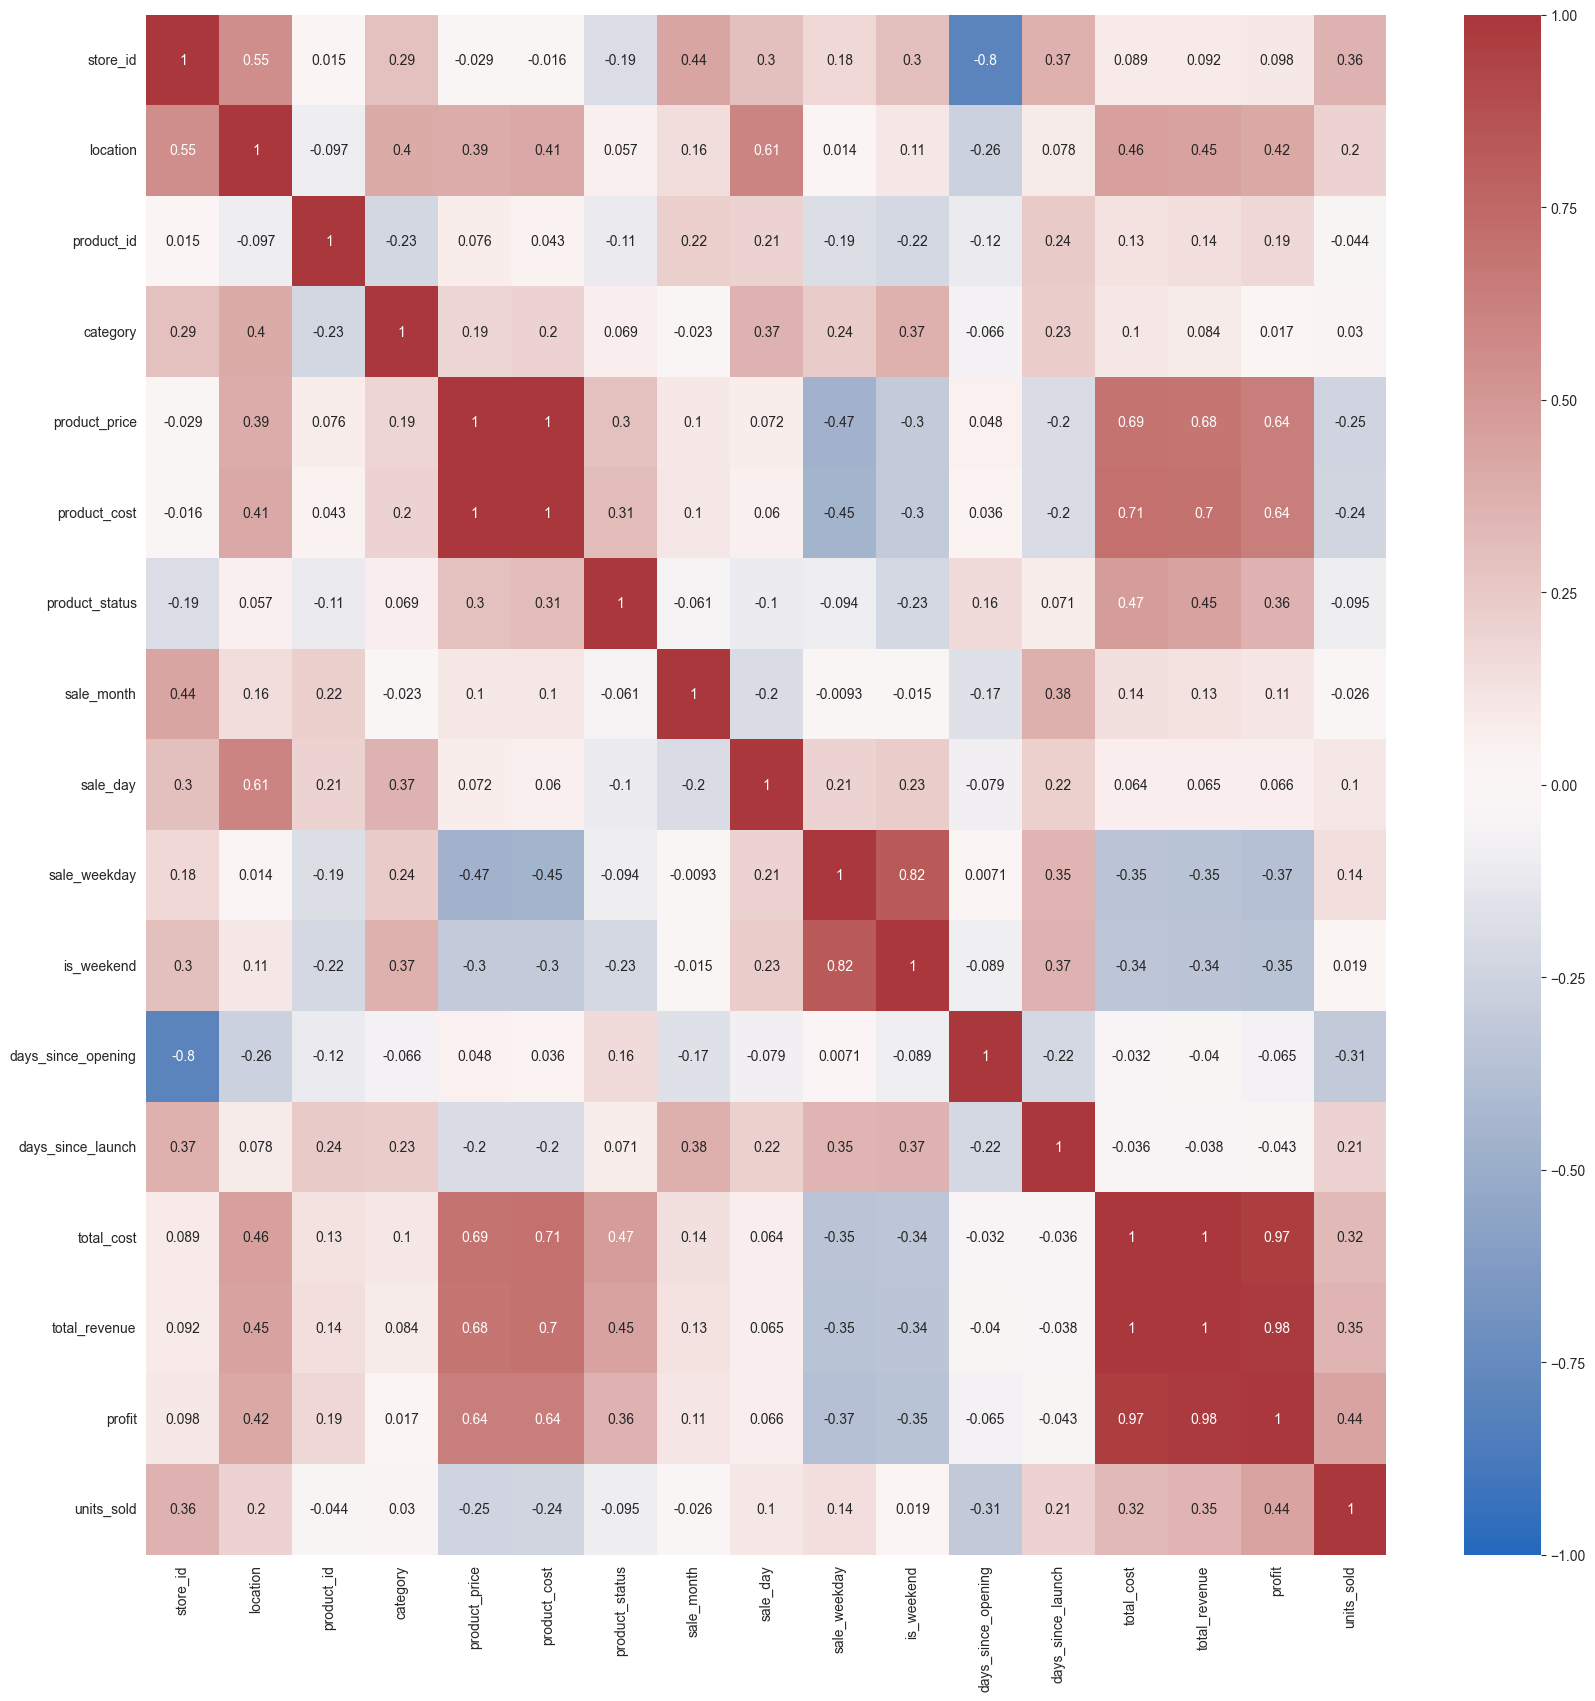

In [79]:
# Gráfico de correlación
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(numeric_only= True),
           vmin=-1,
           vmax=1,
           cmap=sns.color_palette("vlag", as_cmap=True),
           annot=True);

In [80]:
# Obtenemos las correlaciones de todas las variables con la variable objetivo 'units_sold'
units_sold_correlations = df.corr()['units_sold'].sort_values(ascending=False)
units_sold_correlations

units_sold            1.000000
profit                0.439505
store_id              0.361934
total_revenue         0.352237
total_cost            0.322339
days_since_launch     0.205806
location              0.200288
sale_weekday          0.144147
sale_day              0.104355
category              0.029501
is_weekend            0.018935
sale_month           -0.026052
product_id           -0.043843
product_status       -0.095431
product_cost         -0.241448
product_price        -0.249852
days_since_opening   -0.307663
Name: units_sold, dtype: float64

- Manejo de outliers

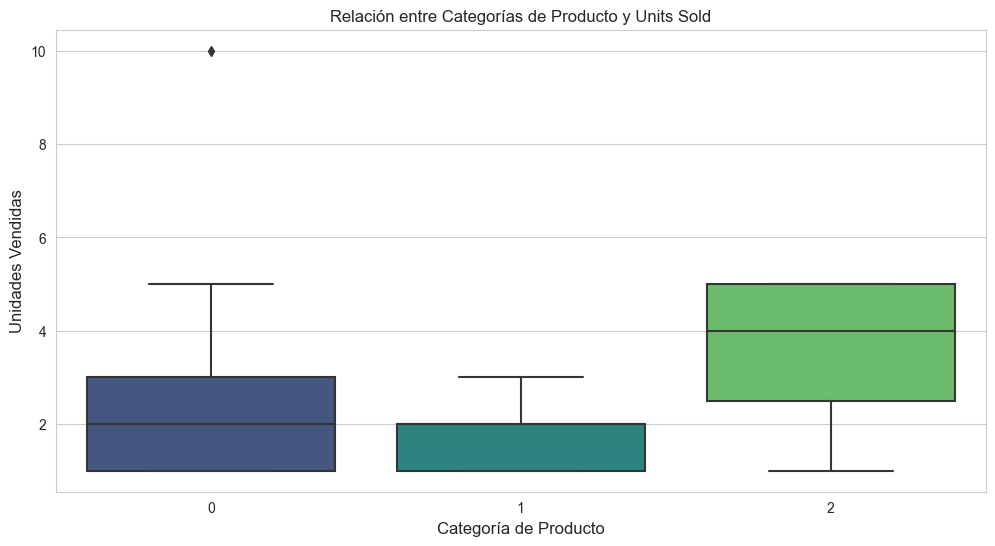

In [81]:
# Gráfico de la relación entre una variable categórica (category) y units_sold
# 1 - Categoría de electrodomésticos
# 2 - Categoría de electrónica
# 3 - Categoría de hogar
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='category', y='units_sold', palette='viridis')
plt.title('Relación entre Categorías de Producto y Units Sold')
plt.xticks(rotation=0)
plt.xlabel('Categoría de Producto', fontsize=12)
plt.ylabel('Unidades Vendidas', fontsize=12)
plt.show()

Aplicamos el rango intercuartílico (IQR) para identificar y eliminar valores extremos en la variable objetivo units_sold.

In [82]:
# Calculamos el rango intercuartílico (IQR) para 'units_sold'
Q1 = df['units_sold'].quantile(0.25)  # Primer cuartil
Q3 = df['units_sold'].quantile(0.75)  # Tercer cuartil
IQR = Q3 - Q1  # Rango intercuartílico

# Definomos los límites para detectar outliers
lower_bound = Q1 - 1.5 * IQR  # Límite inferior
upper_bound = Q3 + 1.5 * IQR  # Límite superior

In [83]:
# Filtramos los datos para excluir los outliers
df = df[(df['units_sold'] >= lower_bound) & (df['units_sold'] <= upper_bound)]

# Comprobamos el resultado
df['units_sold'].describe()

count    30.000000
mean      2.300000
std       1.342925
min       1.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       5.000000
Name: units_sold, dtype: float64

## 8. Elección de las variables para el modelo

- profit, total_revenue, y total_cost muestran correlaciones moderadas (0.43, 0.35, y 0.32, respectivamente). Esto se debe a que están directamente relacionadas con la cantidad de unidades vendidas. Procederemos a eliminarlas por su redunndancia para el modelo de Machine Learning.

- product_price (-0.26) y product_cost (-0.25) muestran que los productos más caros suelen venderse menos, un patrón típico en muchos mercados y que fortalece el EDA. Claves para entender la demanda.
  
- category, product_status, y location : aunque no tienen una correlación directa fuerte, estas variables categóricas pueden capturar patrones importantes en los datos.

- sale_weekday (0.12) y sale_day (0.10) tienen una correlación débil, indicando que el día específico tiene poco impacto en las ventas.
is_weekend y sale_month prácticamente no influyen (correlación cercana a 0).

- days_since_opening muestra una correlación negativa moderada (-0.31), sugiriendo que las tiendas más nuevas venden más. Por otro lado, days_since_launch tiene una correlación positiva débil (0.08).

- Eliminamos las variables que generan redundancia en el análisis y explican lo mismo a partir de la variable objetivo 

In [84]:
# Eliminamos las variables económicas derivadas de 'units_sold'
df.drop(['profit', 'total_revenue', 'total_cost'], axis=1, inplace=True)
# Verificamos las columnas que quedan
df.columns.tolist()

['store_id',
 'location',
 'product_id',
 'category',
 'product_price',
 'product_cost',
 'product_status',
 'sale_month',
 'sale_day',
 'sale_weekday',
 'is_weekend',
 'days_since_opening',
 'days_since_launch',
 'units_sold']

- **Variables indepndientes y variable objetivo**

**Target:**
- **`units_sold`**: número de unidades vendidas.

**Features**
- store_id: identificador único de la tienda.
- location: ubicación de la tienda (Madrid: 0, Barcelona: 1, Sevilla: 2, Valencia: 3, Itinerante: 4, Online: 5, Bilbao: 6).
- product_id: identificador único del producto.
- category: categoría del producto(Electrodomesticos: 0, Electronica: 1, Hogar: 2).
- product_price: precio del producto.
- product_cost: costo del producto.
- product_status: estado del producto (active: 0, paused: 1).
- sale_month: mes de la venta.
- sale_day: día del mes en que se realizó la venta.
- sale_weekday: día de la semana en que se realizó la venta.
- is_weekend: indicador de si la venta ocurrió en un fin de semana (1 = sí, 0 = no).
- days_since_opening: días transcurridos desde la apertura de la tienda hasta la venta.
- days_since_launch: días transcurridos desde el lanzamiento del producto hasta la venta.

### **Guardamos el DataFrame Final obtenido**

In [85]:
# Guardamos el DataFrame final
df.to_csv('..\\data\\df_final_ML.csv', index=False)